# KOH Posterior Analysis using Mici

This notebook looks at the different ways to implement an MCMC algorithm using Gaussian random-walk Metropolis proposal under the Mici framework.

The goal is to discover the best set-up and compare results against the MATLAB code previously implemented.

First, import the required packages and set up the KOH and Mici frameworks.

In [1]:
import matlabmodelnew as mm
from dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from MATLAB_mappings import ell2rho, beta2ell
from jax import jit
import jax.numpy as jnp

import numpy as np
import mici

import matplotlib.pyplot as plt

import arviz

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
seed = 1234
n_chain = 1 # only 1 works on MacOS
n_dim = 7
n_warm_up_iter = 4000
n_main_iter = 10000
rng = np.random.default_rng(seed)

init_states = np.array([[
    map01toR(0.4257), 
    map0inftoR(beta2ell(51.5551)), #these are the beta values!!!
    map0inftoR(beta2ell(3.5455)), 
    # map0inftoR(beta2ell(2)), 
    map0inftoR(0.25557), 
    map0inftoR(37.0552), 
    map0inftoR(10030.5142), 
    map0inftoR(79548.2126)
]])

# param_transform_mici_to_gpjax = lambda x: jnp.array([
#     mapRto01(x[0]), 
#     mapRto0inf(x[1]), 
#     mapRto0inf(x[2]), 
#     mapRto0inf(x[3]), 
#     mapRto0inf(x[4]), 
#     mapRto0inf(x[5]), 
#     mapRto0inf(x[6])
# ])

param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0])
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[3]), 
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6])
    ]
]

tmax = 0.6
tmin = 0.2


##### KOH Model #####
dataloader = DataLoader('data/simple_field.csv', 'data/simple_comp.csv')
data = dataloader.get_data() # loads normalised/standardised data
model = mm.MatlabModel(*data)
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=jitted_neg_log_posterior_density,
    grad_neg_log_dens=lambda q: q * 0,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

## Setup 1

Adapters:
- DualAveragingStepSizeAdapter(0.234)
- OnlineCovarianceMetricAdapter()

Results:
- Fails to achieve the target acceptance rate of 0.234, instead achieves around 0.2
- ESS bulk values are very similar for each variable.
- Parameter estimate for $\theta$ is very good. 
- 

In [3]:
##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.234),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'theta': state.pos[0], 
        'ell_eta_1': state.pos[1], 
        'ell_eta_2': state.pos[2],
        'lambda_eta': state.pos[3],
        'lambda_delta': state.pos[4],
        'lambda_epsilon': state.pos[5],
        'lambda_epsilon_eta': state.pos[6],
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

Sampling stage: Initial fast adaptive [00:00] > Slow adaptive (1/7) [00:00] > Slow adaptive (2/7) [00:00] > Slow adaptive (3/7) [00:00] > Slow adaptive (4/7) [00:00] > Slow adaptive (5/7) [00:01] > Slow adaptive (6/7) [00:03] > Slow adaptive (7/7) [00:08] > Final fast adaptive [00:00] > Main non-adaptive [00:34]

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Chain 1/1: 100%|██████████|10000/10000 [00:34<00:00, 285.81it/s, accept_stat=0.112]

# Analyse the Chains

In [4]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.258,0.146,-0.520,0.011,0.008,0.006,352.0,438.0,NaN
ell_eta_1,-2.332,0.031,-2.383,-2.271,0.002,0.001,303.0,469.0,NaN
ell_eta_2,-0.957,0.056,-1.064,-0.860,0.003,0.002,317.0,425.0,NaN
lambda_eta,-1.349,0.207,-1.714,-0.959,0.011,0.008,345.0,396.0,NaN
lambda_delta,3.504,0.283,2.977,4.024,0.016,0.011,319.0,477.0,NaN
lambda_epsilon,9.048,0.343,8.435,9.675,0.023,0.016,224.0,302.0,NaN
lambda_epsilon_eta,11.263,0.117,11.031,11.472,0.007,0.005,313.0,534.0,NaN


In [5]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

# for i in range(7):
#     print(np.mean(traces['pos'][0][:, i]), '±', np.std(traces['pos'][0][:, i]))

theta :  -0.25819226917078575 ± 0.14607095111605506
ell_eta_1 :  -2.3319931861014416 ± 0.030679674112191625
ell_eta_2 :  -0.9566029331282767 ± 0.05627077900324847
lambda_eta :  -1.348872844210776 ± 0.20710596007827253
lambda_delta :  3.5039660590819652 ± 0.2825116129888911
lambda_epsilon :  9.048393559252899 ± 0.3430866092195144
lambda_epsilon_eta :  11.263325443709089 ± 0.1169186957143753


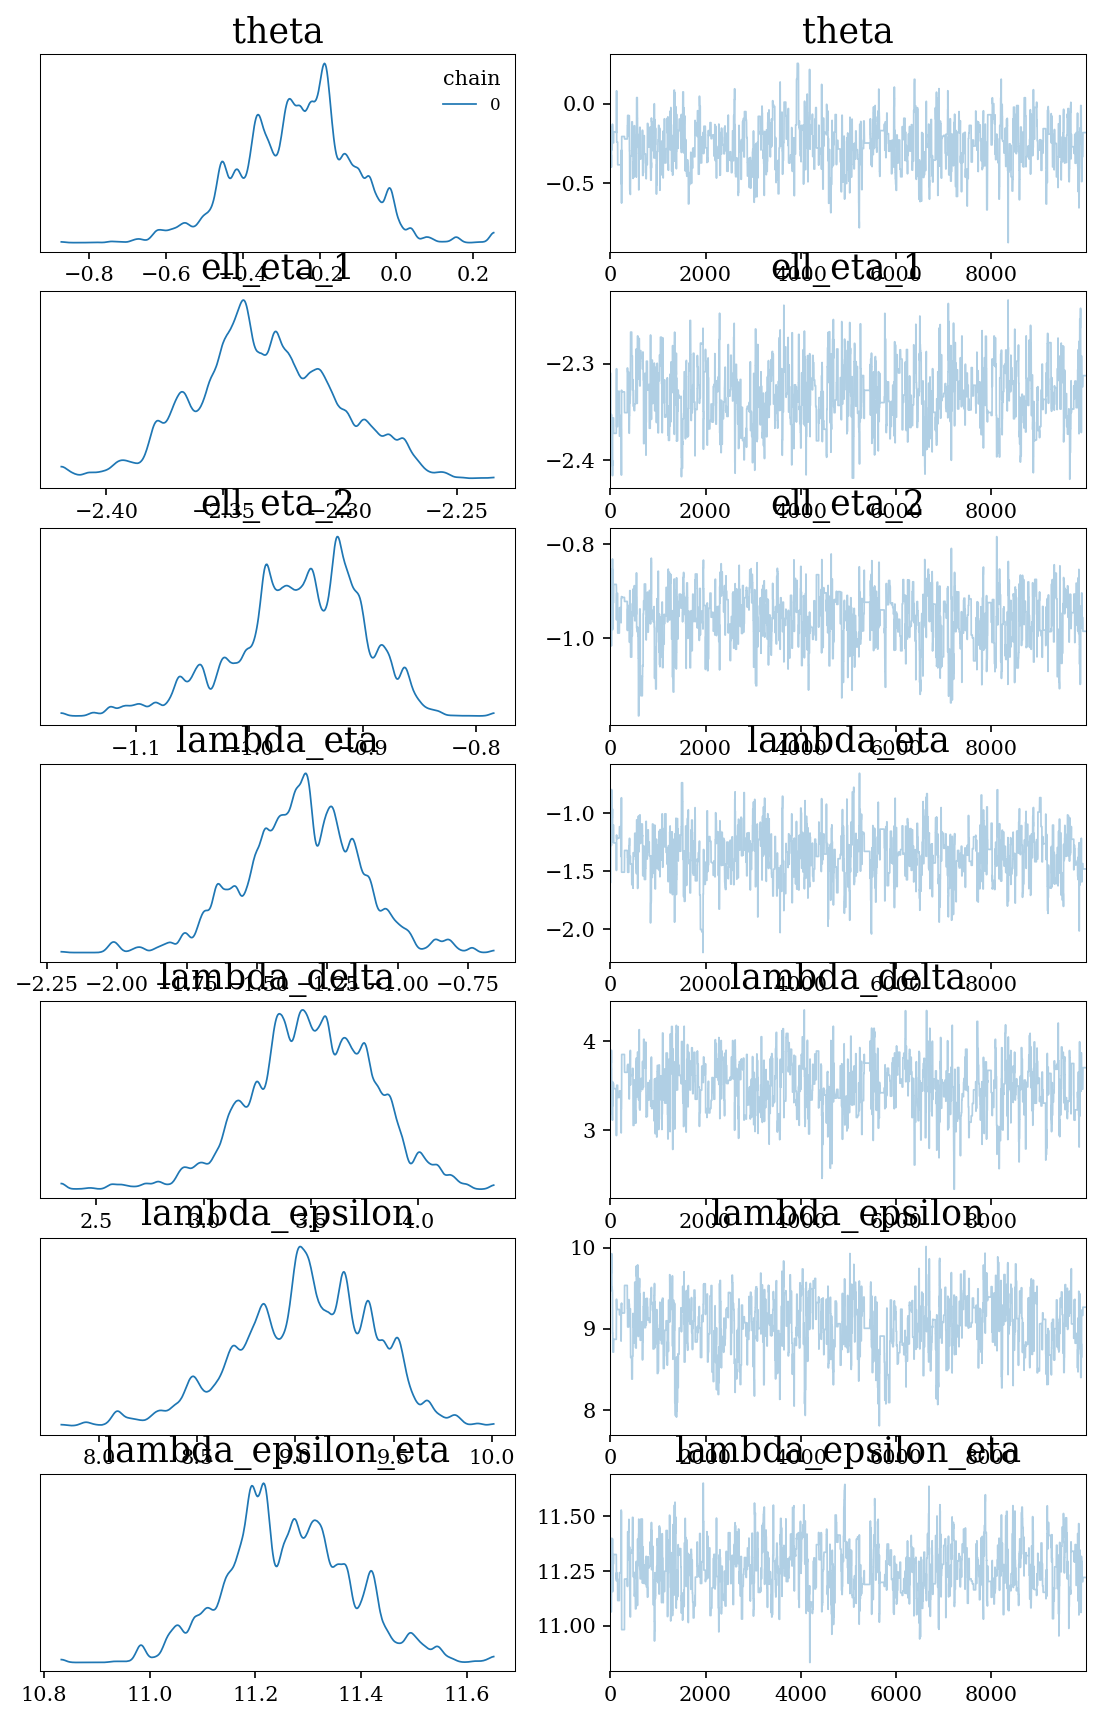

In [6]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()

# Transform the Chains

In [7]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'theta':
        traces_transformed[var] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var == 'ell_eta_1' or var == 'ell_eta_2':
        traces_transformed[var] = ell2rho(mapRto0inf(trace[0]))
    else:
        traces_transformed[var] = mapRto0inf(trace[0])

for var, trace in traces_transformed.items():
    print(var, ": ", np.mean(trace), '±', np.std(trace))


# traces_transformed = {'pos': []}
# traces_transformed['pos'].append(np.empty_like(traces['pos'][0]))
# for i in range(0, 1): # theta
#     traces_transformed['pos'][0][:, i] = mapRto01(traces['pos'][0][:, i])*(tmax-tmin) + tmin
# for i in range(1, 3): # rho_eta, rho_delta
#     traces_transformed['pos'][0][:, i] = ell2rho(mapRto0inf(traces['pos'][0][:, i]))
# for i in range(3, 7): # lambda_eta, lambda_delta, lambda_epsilon, lambda_epsilon_eta
#     traces_transformed['pos'][0][:, i] = mapRto0inf(traces['pos'][0][:, i])

# for i in range(7):
#     print(np.mean(traces_transformed['pos'][0][:, i]), '±', np.std(traces_transformed['pos'][0][:, i]))


theta :  0.4255414963168313 ± 0.014278702720900927
ell_eta_1 :  2.3444941911641833e-06 ± 2.029297183198658e-06
ell_eta_2 :  0.4284594613309433 ± 0.04081206920841679
lambda_eta :  0.26510890246638025 ± 0.05493173948815767
lambda_delta :  34.57040044854628 ± 9.650077834397903
lambda_epsilon :  8998.670345608803 ± 2973.0625336860226
lambda_epsilon_eta :  78448.3715542844 ± 9274.704387609696


In [8]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.426,0.014,0.399,0.451,0.001,0.001,352.0,406.0,NaN
ell_eta_1,0.000,0.000,0.000,0.000,0.000,0.000,303.0,469.0,NaN
ell_eta_2,0.428,0.041,0.350,0.497,0.002,0.002,317.0,425.0,NaN
lambda_eta,0.265,0.055,0.170,0.366,0.003,0.002,345.0,396.0,NaN
lambda_delta,34.570,9.651,16.239,51.236,0.529,0.375,319.0,477.0,NaN
lambda_epsilon,8998.670,2973.211,3953.337,14377.136,199.090,140.963,224.0,302.0,NaN
lambda_epsilon_eta,78448.372,9275.168,61668.614,95891.313,528.371,373.969,313.0,534.0,NaN


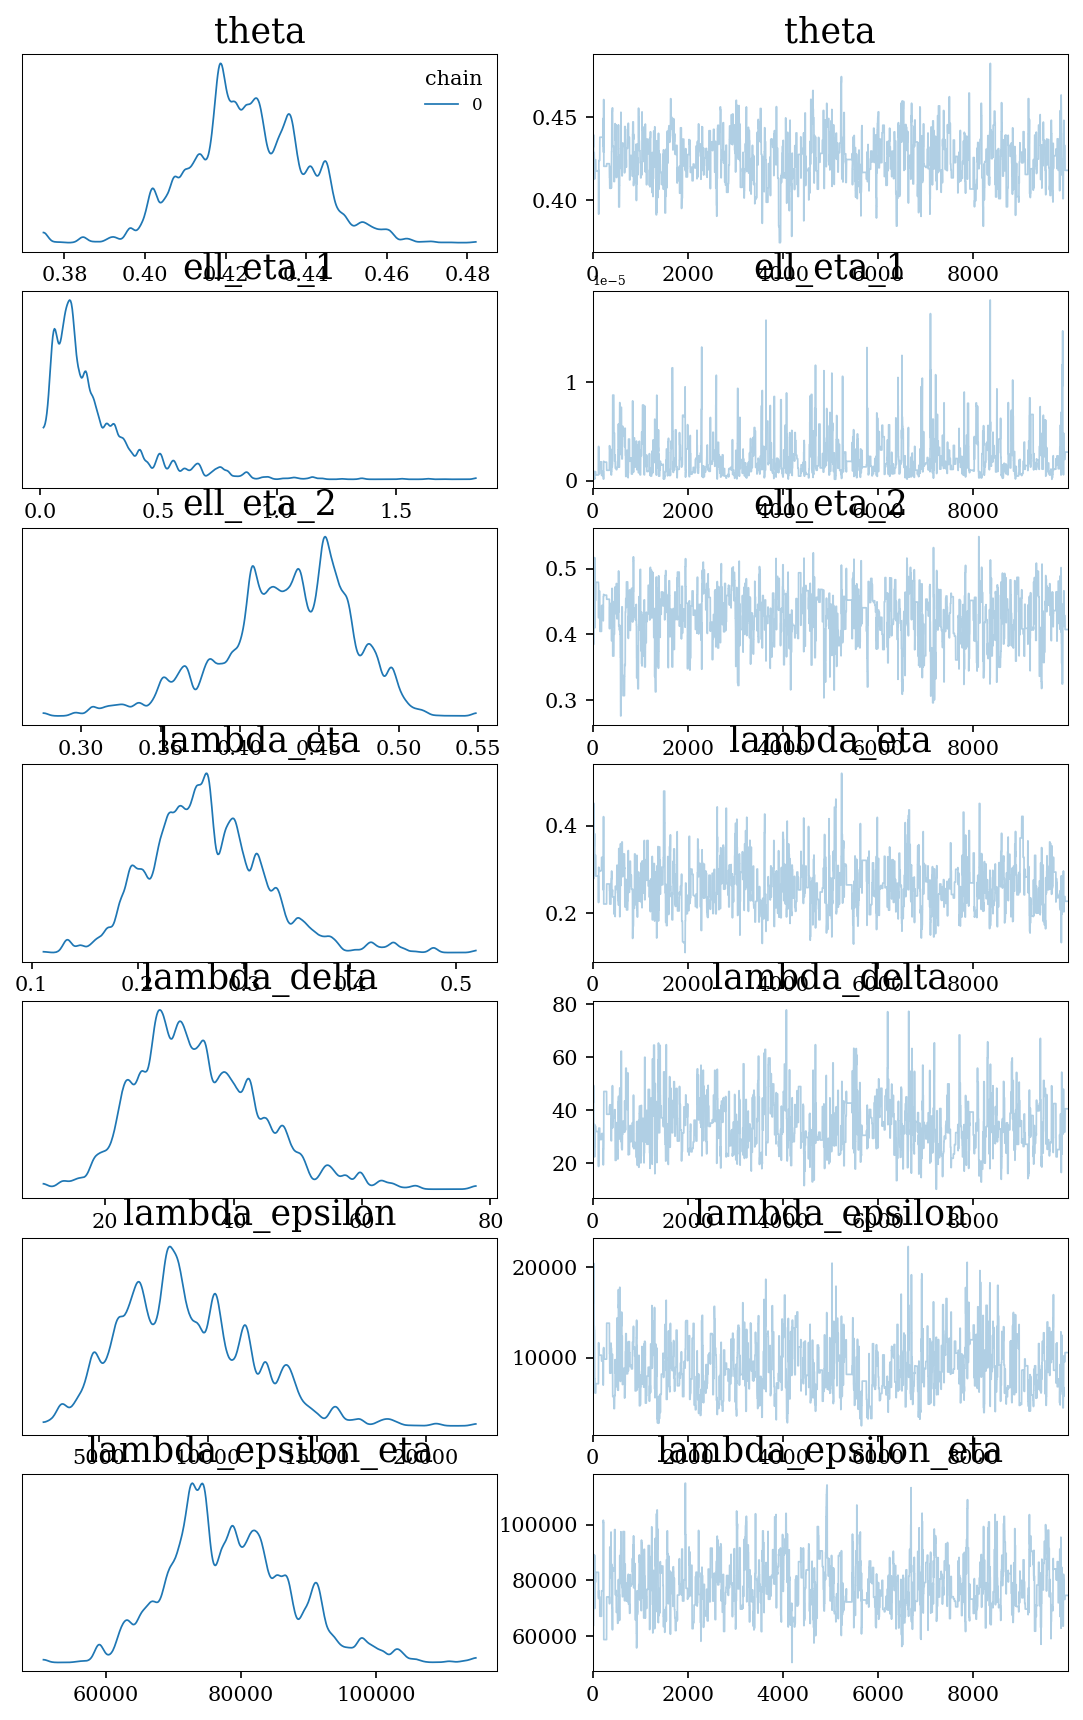

In [9]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()